# testing loading EarthSatellite instances from a json file of OMM dictionaries

In [1]:
import json
import os
import datetime
from skyfield.api import EarthSatellite, load, wgs84
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import cartopy.crs as ccrs

/home/users/eeasm/mambaforge-pypy3/envs/ssncs/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [19]:
import ssncs
help(ssncs)

ModuleNotFoundError: No module named 'ssncs'

In [3]:
import skyfield
print(skyfield.VERSION)

(1, 53)


In [4]:
ts = load.timescale()

In [5]:
#target_file = "../data/icesat2_test.json"
target_file = "../data/earthcare_test.json"

In [6]:
os.path.isfile(target_file)

True

In [7]:
with open(target_file, "r") as f:
    omm_dict = json.load(f)
omm_dict

[{'OBJECT_NAME': 'EARTHCARE',
  'OBJECT_ID': '2024-101A',
  'EPOCH': '2024-05-29T01:24:48.914208',
  'MEAN_MOTION': 15.55284978,
  'ECCENTRICITY': 0.0004125,
  'INCLINATION': 96.978,
  'RA_OF_ASC_NODE': 278.3287,
  'ARG_OF_PERICENTER': 130.4085,
  'MEAN_ANOMALY': 348.4676,
  'EPHEMERIS_TYPE': 0,
  'CLASSIFICATION_TYPE': 'U',
  'NORAD_CAT_ID': 59908,
  'ELEMENT_SET_NO': 999,
  'REV_AT_EPOCH': 1,
  'BSTAR': 0,
  'MEAN_MOTION_DOT': -9.1e-07,
  'MEAN_MOTION_DDOT': 0},
 {'OBJECT_NAME': 'EARTHCARE',
  'OBJECT_ID': '2024-101A',
  'EPOCH': '2024-05-29T02:58:31.276704',
  'MEAN_MOTION': 15.55298826,
  'ECCENTRICITY': 0.0004183,
  'INCLINATION': 96.9785,
  'RA_OF_ASC_NODE': 278.3904,
  'ARG_OF_PERICENTER': 133.0935,
  'MEAN_ANOMALY': 349.8946,
  'EPHEMERIS_TYPE': 0,
  'CLASSIFICATION_TYPE': 'U',
  'NORAD_CAT_ID': 59908,
  'ELEMENT_SET_NO': 999,
  'REV_AT_EPOCH': 2,
  'BSTAR': 0,
  'MEAN_MOTION_DOT': -9.1e-07,
  'MEAN_MOTION_DDOT': 0},
 {'OBJECT_NAME': 'EARTHCARE',
  'OBJECT_ID': '2024-101A',
  '

In [8]:
sat_dict = {
    datetime.datetime.fromisoformat(omm["EPOCH"]).replace(tzinfo=datetime.timezone.utc): EarthSatellite.from_omm(ts=ts, element_dict=omm)
    for omm in omm_dict
}

In [9]:
sat_dict

{datetime.datetime(2024, 5, 29, 1, 24, 48, 914208, tzinfo=datetime.timezone.utc): <EarthSatellite EARTHCARE catalog #59908 epoch 2024-05-29 01:24:49 UTC>,
 datetime.datetime(2024, 5, 29, 2, 58, 31, 276704, tzinfo=datetime.timezone.utc): <EarthSatellite EARTHCARE catalog #59908 epoch 2024-05-29 02:58:31 UTC>,
 datetime.datetime(2024, 6, 3, 7, 31, 45, 756192, tzinfo=datetime.timezone.utc): <EarthSatellite EARTHCARE catalog #59908 epoch 2024-06-03 07:31:46 UTC>,
 datetime.datetime(2024, 6, 3, 19, 52, 57, 339552, tzinfo=datetime.timezone.utc): <EarthSatellite EARTHCARE catalog #59908 epoch 2024-06-03 19:52:57 UTC>,
 datetime.datetime(2024, 6, 4, 8, 14, 8, 330208, tzinfo=datetime.timezone.utc): <EarthSatellite EARTHCARE catalog #59908 epoch 2024-06-04 08:14:08 UTC>}

In [10]:
times = pd.date_range(
    start = datetime.datetime(2024, 5, 29, 14, 15, 25),
    end = datetime.datetime(2024, 9, 10, 21, 40, 2),
    #end = datetime.datetime(2024, 5, 29, 21, 40, 2),
    freq="60s",
    unit="s"
).to_pydatetime()
times = np.array([
    dtime.replace(tzinfo=datetime.timezone.utc)
    for dtime in times
])
times.shape

(150205,)

In [11]:
sat_lerp_contrib = dict()

lerp = lambda x, x0, x1, f0, f1: ( f0*(x1-x) + f1*(x-x0) )/(x1-x0) if x1-x0 != 0 else f0
def lerp_contrib(x, x_target, x_other):
    if x_target - x_other == 0 or x_target - x_other == datetime.timedelta(0):
        return np.ones(x.shape)
    return ((x-x_other)/(x_target-x_other)).astype(float)
    

for i, (epoch, sat) in enumerate(sat_dict.items()):
    before_epoch = list(sat_dict.keys())[np.clip(i-1, 0, len(sat_dict)-1)]
    after_epoch = list(sat_dict.keys())[np.clip(i+1, 0, len(sat_dict)-1)]
    
    contrib_before = np.clip(lerp_contrib( times, epoch, before_epoch ), 0, 1)[times <= epoch]
    contrib_after = np.clip(lerp_contrib( times, epoch, after_epoch ), 0, 1)[times >= epoch]
    
    sat_lerp_contrib[epoch] = np.concat([contrib_before, contrib_after])

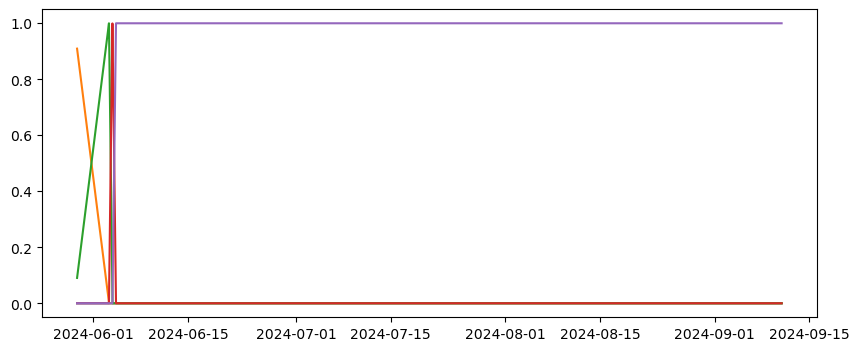

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,4))

for epoch, times_contrib in sat_lerp_contrib.items():
    ax.plot(times, times_contrib, label=epoch)
#plt.legend()
plt.show()

In [13]:
ts_times = ts.from_datetimes(times)
ts_times

<Time tt=[2460460.0948400926 ... 2460564.4031734257] len=150205>

In [14]:
%%time
positions_at_times = {
    epoch: sat.at(ts_times)
    for epoch, sat in sat_dict.items()
}
positions_at_times

CPU times: user 28.9 s, sys: 484 ms, total: 29.4 s
Wall time: 6.45 s


{datetime.datetime(2024, 5, 29, 1, 24, 48, 914208, tzinfo=datetime.timezone.utc): <Geocentric ICRS position and velocity at date t center=399 target=-159908>,
 datetime.datetime(2024, 5, 29, 2, 58, 31, 276704, tzinfo=datetime.timezone.utc): <Geocentric ICRS position and velocity at date t center=399 target=-159908>,
 datetime.datetime(2024, 6, 3, 7, 31, 45, 756192, tzinfo=datetime.timezone.utc): <Geocentric ICRS position and velocity at date t center=399 target=-159908>,
 datetime.datetime(2024, 6, 3, 19, 52, 57, 339552, tzinfo=datetime.timezone.utc): <Geocentric ICRS position and velocity at date t center=399 target=-159908>,
 datetime.datetime(2024, 6, 4, 8, 14, 8, 330208, tzinfo=datetime.timezone.utc): <Geocentric ICRS position and velocity at date t center=399 target=-159908>}

In [15]:
delta_pos = list(positions_at_times.values())[-1] - list(positions_at_times.values())[0]
np.max(np.abs(delta_pos.xyz.m), axis=-1)

array([13464727.55106066,  7191822.67422585, 13454417.96631394])

In [16]:
%%time
latlon_at_times = {
    epoch: wgs84.latlon_of(position)
    for epoch, position in positions_at_times.items()
}
latlon_at_times

CPU times: user 70.7 ms, sys: 4.98 ms, total: 75.7 ms
Wall time: 76.9 ms


{datetime.datetime(2024, 5, 29, 1, 24, 48, 914208, tzinfo=datetime.timezone.utc): (<Angle 150205 values from -52deg 52' 47.1" to -50deg 10' 26.8">,
  <Angle 150205 values from -11deg 51' 25.1" to 73deg 46' 59.2">),
 datetime.datetime(2024, 5, 29, 2, 58, 31, 276704, tzinfo=datetime.timezone.utc): (<Angle 150205 values from -52deg 54' 32.5" to -45deg 02' 50.8">,
  <Angle 150205 values from -11deg 52' 09.6" to 72deg 24' 05.4">),
 datetime.datetime(2024, 6, 3, 7, 31, 45, 756192, tzinfo=datetime.timezone.utc): (<Angle 150205 values from -53deg 14' 34.9" to -13deg 21' 31.3">,
  <Angle 150205 values from -11deg 58' 53.3" to -116deg 02' 33.6">),
 datetime.datetime(2024, 6, 3, 19, 52, 57, 339552, tzinfo=datetime.timezone.utc): (<Angle 150205 values from -53deg 22' 08.9" to -64deg 13' 37.6">,
  <Angle 150205 values from -12deg 01' 31.0" to -128deg 57' 54.2">),
 datetime.datetime(2024, 6, 4, 8, 14, 8, 330208, tzinfo=datetime.timezone.utc): (<Angle 150205 values from -53deg 33' 31.9" to -31deg 48'

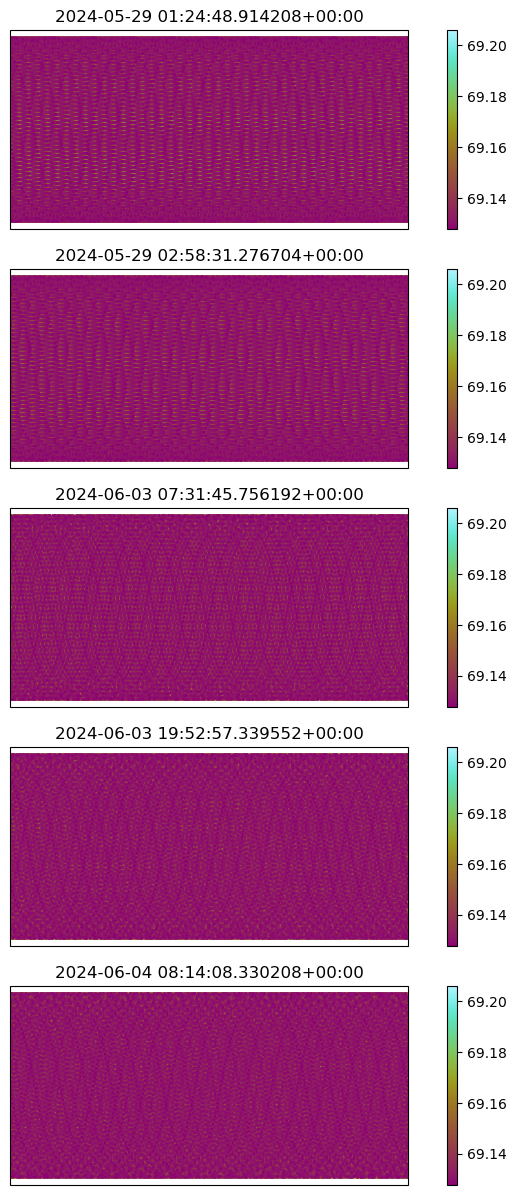

CPU times: user 5.42 s, sys: 43.5 ms, total: 5.47 s
Wall time: 5.51 s


In [17]:
%%time
N = len(latlon_at_times)
fig, axs = plt.subplots(
    N, 1, 
    figsize=(10,3*N), 
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

for ax, (epoch, latlon) in zip(axs, latlon_at_times.items()):
    ax.set_title(epoch)
    sca = ax.scatter(
        x=latlon[1].degrees,
        y=latlon[0].degrees,
        s=1,
        c=ts_times.delta_t,
        transform=ccrs.Geodetic(),
        cmap=cm.hawaii
    )
    plt.colorbar(sca)

plt.show()

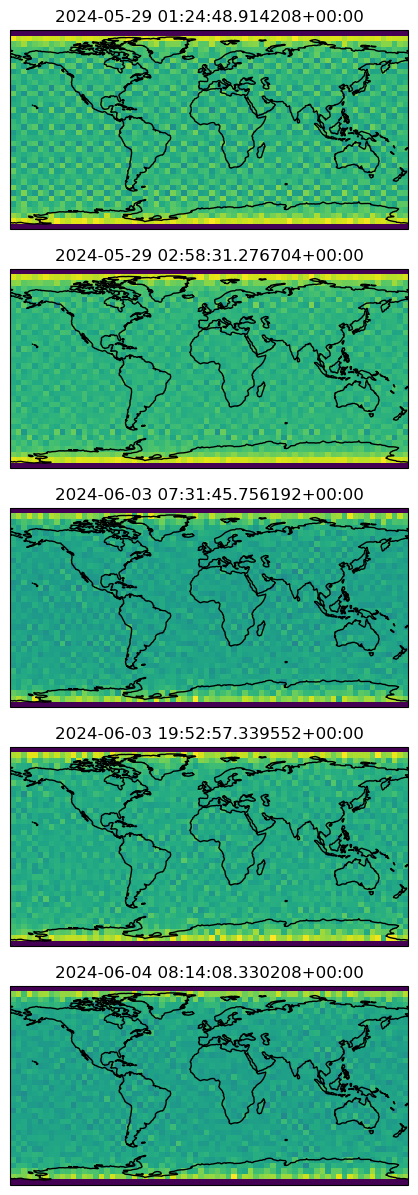

CPU times: user 136 ms, sys: 22.7 ms, total: 158 ms
Wall time: 179 ms


In [18]:
%%time
N = len(latlon_at_times)
fig, axs = plt.subplots(
    N, 1, 
    figsize=(10,3*N), 
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

for ax, (epoch, latlon) in zip(axs, latlon_at_times.items()):
    ax.set_title(epoch)
    histob = ax.hist2d(
        x=latlon[1].degrees,
        y=latlon[0].degrees,
        bins=[np.arange(-180,181,5), np.arange(-90,91,5)],
        cmap="viridis"
    )
    ax.coastlines()
    #plt.colorbar(histob)

plt.show()